# Han et al. (2022)

This Jupyter Notebook was used to generate the figures for Han et al. (2022) 

## Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import re
import subprocess

import baltic as bt 

from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle as rect
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap 
import matplotlib.patches as patches

import calendar
import geopandas as gpd 
import geoplot
import json
import ete3 

import seaborn as sns
import datetime as dt
from Bio import SeqIO

/opt/anaconda3/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/opt/anaconda3/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


## Read kiemsurveillance meta data

In [2]:
meta_data = pd.read_csv('./data/abridged_metadata.csv') 
# change date from str to datetime 
meta_data['date'] = pd.to_datetime(meta_data['date'])
display (meta_data.head())

,sname,date,nextclade,variant,mapped_ggd,pangolin,mapped_nextclade
0,hCoV-19/Netherlands/NH-RIVM-20002/2020,2020-11-20,20A,NaN,GGD Amsterdam,B.1.221,20A
1,hCoV-19/Netherlands/NH-RIVM-20003/2020,2020-11-20,20A,NaN,GGD Amsterdam,B.1.221,20A
2,hCoV-19/Netherlands/NH-RIVM-20004/2020,2020-11-20,20A,NaN,GGD Amsterdam,B.1.160,20A
3,hCoV-19/Netherlands/NH-RIVM-20005/2020,2020-11-20,20E (EU1),NaN,GGD Amsterdam,B.1.177.81,20E (EU1)
4,hCoV-19/Netherlands/NH-RIVM-20006/2020,2020-11-21,20A,NaN,GGD Amsterdam,B.1.221,20A


In [3]:
nl_case_density = pd.read_excel('./data/COVID_NLcases_sept_sept_100000.xlsx').set_index('GGD-regio')
date_range = sorted(nl_case_density)[:-2]
nl_case_density = nl_case_density[date_range]
# get decimal date range 
decimal_date_range = [bt.decimalDate(dt.datetime.strftime(date, format='%Y-%m-%d')) for date in date_range]
# get week labels 
week_labels = ['W%i/20'%(i) for i in np.arange(39, 54)] + ['W%i/21'%(i) for i in np.arange(1, 38)]
week_labels = week_labels[:len(decimal_date_range)]
display (nl_case_density.head())

nl_case_counts = pd.read_excel('./data/COVID_NLcases_sept_sept.xlsx').set_index('GGD-regio')
nl_case_counts.loc['total'] = nl_case_counts.sum(axis=0)
nl_case_counts = nl_case_counts[date_range]
display (nl_case_counts.head())

nl_case_per100k = pd.read_excel('./data/COVID_NLcases_sept_sept_100000.xlsx').set_index('GGD-regio')
print ('***')
display (nl_case_per100k)

nl_sequence_counts = []
for d, date in enumerate(date_range):
    date_meta_data = meta_data[(meta_data['date']>=date - dt.timedelta(days=6))&(meta_data['date']<=date)].copy()
    # get fraction of clades for the week 
    row = {'date':date, 'seq_n':len(date_meta_data)}
    for clade in date_meta_data['mapped_nextclade'].unique(): 
        row[clade] = len(date_meta_data[date_meta_data['mapped_nextclade']==clade])/len(date_meta_data)
    nl_sequence_counts.append(row)
nl_sequence_counts = pd.DataFrame.from_dict(nl_sequence_counts).set_index('date')
nl_sequence_counts = nl_sequence_counts.fillna(0.)

nextclade_list = sorted(set(nl_sequence_counts)-set(['seq_n']))

display (nl_sequence_counts.head())

,2020-09-29,2020-10-06,2020-10-13,2020-10-20,2020-10-27,2020-11-03,2020-11-10,2020-11-17,2020-11-24,2020-12-01,...,2021-06-29,2021-07-06,2021-07-13,2021-07-20,2021-07-27,2021-08-03,2021-08-10,2021-08-17,2021-08-24,2021-08-31
GGD-regio,,,,,,,,,,,,,,,,,,,,,
GGD Groningen,74.8,102.9,151.6,163.7,114.2,88.8,70.5,72.7,98.3,95.8,...,15.7,72.0,572.5,485.1,194.8,106.9,80.1,86.5,93.0,94.0
GGD Fryslan,57.4,83.7,140.2,143.4,130.5,120.9,79.4,91.2,103.1,93.7,...,9.7,19.1,182.3,233.2,138.8,93.1,82.0,81.1,96.7,109.0
GGD Drenthe,68.7,69.9,172.8,205.6,183.9,143.8,120.7,107.8,132.3,101.1,...,9.5,11.5,141.0,169.7,96.8,64.4,45.8,65.6,63.7,78.6
GGD IJsselland,56.3,85.6,150.4,197.6,239.8,193.5,162.6,125.0,135.7,155.1,...,13.9,25.8,196.1,290.4,137.0,95.4,85.3,86.6,112.0,93.1
GGD Regio Twente,57.7,137.1,239.1,310.1,446.5,420.1,329.9,301.4,250.5,228.0,...,23.3,65.1,283.3,339.7,195.9,111.9,104.6,101.7,106.2,110.8


,2020-09-29,2020-10-06,2020-10-13,2020-10-20,2020-10-27,2020-11-03,2020-11-10,2020-11-17,2020-11-24,2020-12-01,...,2021-06-29,2021-07-06,2021-07-13,2021-07-20,2021-07-27,2021-08-03,2021-08-10,2021-08-17,2021-08-24,2021-08-31
GGD-regio,,,,,,,,,,,,,,,,,,,,,
GGD Groningen,438,603,888,959,669,520,413,426,576,561,...,92,422,3354,2842,1141,626,469,507,546,552
GGD Fryslan,373,544,911,932,848,786,516,593,670,609,...,63,124,1185,1516,902,605,533,527,630,710
GGD Drenthe,339,345,853,1015,908,710,596,532,653,499,...,47,57,696,838,478,318,226,324,315,389
GGD IJsselland,299,455,799,1050,1274,1028,864,664,721,824,...,74,137,1042,1543,728,507,453,460,599,498
GGD Regio Twente,364,865,1509,1957,2818,2651,2082,1902,1581,1439,...,147,411,1788,2144,1236,706,660,642,671,700


***


,2020-09-29,2020-10-06,2020-10-13,2020-10-20,2020-10-27,2020-11-03,2020-11-10,2020-11-17,2020-11-24,2020-12-01,...,2021-07-13,2021-07-20,2021-07-27,2021-08-03,2021-08-10,2021-08-17,2021-08-24,2021-08-31,2021-09-07,2021-09-14
GGD-regio,,,,,,,,,,,,,,,,,,,,,
GGD Groningen,74.8,102.9,151.6,163.7,114.2,88.8,70.5,72.7,98.3,95.8,...,572.5,485.1,194.8,106.9,80.1,86.5,93.0,94.0,88.8,75.0
GGD Fryslan,57.4,83.7,140.2,143.4,130.5,120.9,79.4,91.2,103.1,93.7,...,182.3,233.2,138.8,93.1,82.0,81.1,96.7,109.0,142.8,132.2
GGD Drenthe,68.7,69.9,172.8,205.6,183.9,143.8,120.7,107.8,132.3,101.1,...,141.0,169.7,96.8,64.4,45.8,65.6,63.7,78.6,91.4,70.5
GGD IJsselland,56.3,85.6,150.4,197.6,239.8,193.5,162.6,125.0,135.7,155.1,...,196.1,290.4,137.0,95.4,85.3,86.6,112.0,93.1,103.4,78.9
GGD Regio Twente,57.7,137.1,239.1,310.1,446.5,420.1,329.9,301.4,250.5,228.0,...,283.3,339.7,195.9,111.9,104.6,101.7,106.2,110.8,110.3,92.1
GGD Noord- en Oost-Gelderland,53.3,88.8,148.8,192.8,202.8,265.4,191.8,163.5,163.1,162.0,...,180.4,323.3,188.8,105.5,73.7,83.6,77.8,76.6,90.2,79.0
Veiligheids- en Gezondheidsregio Gelderland-Midden,86.4,124.2,197.2,252.1,322.1,315.7,229.7,194.5,219.6,220.9,...,203.3,354.0,200.5,105.1,95.2,94.0,89.0,107.4,108.2,79.4
GGD Gelderland-Zuid,109.3,141.7,216.0,280.1,300.2,325.0,247.7,207.4,196.6,199.4,...,237.5,490.9,230.4,105.8,91.3,90.3,103.0,79.3,78.0,77.5
GGD Regio Utrecht,119.6,183.9,323.1,393.9,461.5,389.3,242.9,225.3,223.1,211.8,...,455.6,419.2,199.6,106.2,87.2,91.3,91.7,107.4,103.1,97.6


,seq_n,20B,20E (EU1),20A,20D,20C,"20I (Alpha, V1)",20G,"20H (Beta, V2)",19B,...,19A,21E (Theta),21C (Epsilon),21B (Kappa),21H (Mu),21J (Delta),21F (Iota),21A (Delta),21I (Delta),21G (Lambda)
date,,,,,,,,,,,,,,,,,,,,,
2020-09-29,11,0.181818,0.181818,0.636364,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-06,9,0.222222,0.222222,0.555556,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-13,16,0.000000,0.437500,0.562500,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-20,25,0.000000,0.320000,0.680000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-27,35,0.142857,0.371429,0.457143,0.028571,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Figure 1

In [4]:
major_events = {'2020-10-14':'Partial lockdown', 
                '2020-12-15':'Strict lockdown', 
                '2021-04-28':'Step 1 reopening',
                '2021-05-19':'Step 2 reopening',
                '2021-06-05':'Step 3 reopening',
                '2021-06-24':'Step 4 reopening',}

# Load MCC tree 
ml_tree_fpath = "./trees/masked_rep_nl.mcc.tre"
ml_tree = bt.loadNexus(ml_tree_fpath, absoluteTime=False)
ml_tree.traverse_tree() ## required to set heights

# traverse tree to get most_recent_date 
most_recent_date = max([bt.decimalDate(k.name.split("|")[1]) for k in ml_tree.Objects if k.branchType == "leaf"])
ml_tree.traverse_tree() ## required to set heights
ml_tree.setAbsoluteTime(most_recent_date) ## set absolute time of all branches by specifying date of most recent tip

# add traits to tree
leaf_n = 0 
for k in ml_tree.Objects: 
    if k.branchType == "leaf":
        leaf_n += 1
        sname = k.name.split('|')[0]
        clade = meta_data[meta_data['sname']==sname]['mapped_nextclade'].iloc[0]
        ggd = meta_data[meta_data['sname']==sname]['mapped_ggd'].iloc[0]
        k.traits["clade"] = clade
        k.traits['ggd'] = ggd

In [5]:
# load netherlands geopandas 
geomap_data = gpd.read_file("./data/COVID-19_-_Actuele_gegevens_RIVM_(vlakken).geojson")
# standardise names
geomap_data['GGD_regio'] = geomap_data['GGD_regio'].str.replace('GGD Fryslân', 'GGD Fryslan')
geomap_data['GGD_regio'] = geomap_data['GGD_regio'].str.replace('GGD Ijsselland', 'GGD IJsselland')
geomap_data['GGD_regio'] = geomap_data['GGD_regio'].str.replace('GGD Twente', 'GGD Regio Twente')
geomap_data['GGD_regio'] = geomap_data['GGD_regio'].str.replace('Dienst Gezondheid & Jeugd Zuid-Holland Zuid', 'Dienst Gezondheid & Jeugd ZHZ')
geomap_data['GGD_regio'] = geomap_data['GGD_regio'].str.replace('GGD Drente', 'GGD Drenthe')
geomap_data['GGD_regio'] = geomap_data['GGD_regio'].str.replace('GGD regio Utrecht', 'GGD Regio Utrecht')

ggd_to_color = {'GGD Regio Utrecht':"#8dd3c7", 'GGD Flevoland':'#fccde5', 'GGD Fryslan':"#ffed6f", 'GGD Groningen':'#ffffb3', 
                'GGD Drenthe':'#ccebc5', 'GGD Zeeland':'#bebada',
                'GGD Limburg-Noord':'#bdbdbd', 'GGD Zuid-Limburg':'#636363', 
                'GGD West-Brabant':'#cb181d', 'GGD Hart voor Brabant':'#fb6a4a', 'GGD Brabant-Zuidoost':'#fcae91', 
                'GGD Noord- en Oost-Gelderland':'#d94701', 'Veiligheids- en Gezondheidsregio Gelderland-Midden':'#d94701', 'GGD Gelderland-Zuid':'#d94701', 
                'GGD IJsselland':'#238b45', 'GGD Regio Twente':'#bae4b3',
                'GGD Hollands-Midden':'#08519c', 'GGD Haaglanden':'#3182bd', 'GGD Rotterdam-Rijnmond':'#6baed6', 'Dienst Gezondheid & Jeugd ZHZ':'#bdd7e7',
                'GGD Gooi en Vechtstreek':"#54278f", 'GGD Amsterdam':'#756bb1', 'GGD Kennemerland':'#9e9ac8', 'GGD Zaanstreek/Waterland':'#bcbddc', 'GGD Hollands-Noorden':'#dadaeb'
                }
ggd_list = list(ggd_to_color.keys())
ggdid_to_color = {g/(len(ggd_list)-1):ggd_to_color[ggd] for g, ggd in enumerate(ggd_list)}

geomap_data["ggd_id"] = geomap_data["GGD_regio"]
geomap_data = geomap_data.replace({"ggd_id":{ggd:g for g, ggd in enumerate(ggd_list)}})

pop_n = geomap_data['Bevolkingsaantal'].sum()
for ggd_id in geomap_data['ggd_id'].unique(): 
    idx_arr = geomap_data[geomap_data['ggd_id']==ggd_id].index
    geomap_data.loc[idx_arr, 'pop_density_cat'] = np.around(100 * geomap_data[geomap_data['ggd_id']==ggd_id]['Bevolkingsaantal'].sum()/pop_n).astype(int)
    #print ()

print (geomap_data['pop_density_cat'].min(), geomap_data['pop_density_cat'].max())
print (list(geomap_data))
display (geomap_data.head())

1.0 8.0
['Gemeentenaam', 'Gemeentecode', 'Gemeentenummer', 'Provincie', 'Provinciecode', 'Provincienummer', 'Veiligheidsregio', 'Veiligheidsregiocode', 'Veiligheidsregionummer', 'GGD_regio', 'GGD_regiocode', 'GGD_regionummer', 'Shape__Area', 'Shape__Length', 'Datum', 'Meldingen', 'Ziekenhuisopnamen', 'Overleden', 'Bevolkingsaantal', 'Meldingen_100000', 'Ziekenhuisopnamen_100000', 'Overleden_100000', 'ObjectId', 'geometry', 'ggd_id', 'pop_density_cat']


,Gemeentenaam,Gemeentecode,Gemeentenummer,Provincie,Provinciecode,Provincienummer,Veiligheidsregio,Veiligheidsregiocode,Veiligheidsregionummer,GGD_regio,...,Ziekenhuisopnamen,Overleden,Bevolkingsaantal,Meldingen_100000,Ziekenhuisopnamen_100000,Overleden_100000,ObjectId,geometry,ggd_id,pop_density_cat
0,'s-Gravenhage,GM0518,518,Zuid-Holland,PV28,28,Haaglanden,VR15,15,GGD Haaglanden,...,1667,551,545163,9802.6,305.8,101.1,1,"MULTIPOLYGON (((4.30286 52.12836, 4.32989 52.1...",17,6.0
1,'s-Hertogenbosch,GM0796,796,Noord-Brabant,PV30,30,Brabant-Noord,VR21,21,GGD Hart voor Brabant,...,256,171,155113,10836.0,165.0,110.2,2,"POLYGON ((5.29145 51.67483, 5.29056 51.67743, ...",9,6.0
2,Aa en Hunze,GM1680,1680,Drenthe,PV22,22,Drenthe,VR03,3,GGD Drenthe,...,7,20,25453,5523.9,27.5,78.6,3,"POLYGON ((6.64859 53.02633, 6.64466 53.03939, ...",4,3.0
3,Aalsmeer,GM0358,358,Noord-Holland,PV27,27,Amsterdam-Amstelland,VR13,13,GGD Amsterdam,...,37,26,31857,9762.4,116.1,81.6,4,"POLYGON ((4.74670 52.27225, 4.75016 52.27334, ...",21,6.0
4,Aalten,GM0197,197,Gelderland,PV25,25,Noord- en Oost-Gelderland,VR06,6,GGD Noord- en Oost-Gelderland,...,32,22,27117,8894.8,118.0,81.1,5,"POLYGON ((6.47606 51.90197, 6.47376 51.90506, ...",11,5.0


In [6]:
age_positivity_df = pd.read_excel("./data/nl_epi_data.xlsx", sheet_name='agepos').set_index("Date")
for r, row in age_positivity_df.iterrows(): 
    age_positivity_df.loc[r] = age_positivity_df.loc[r]/age_positivity_df.loc[r].sum()
display (age_positivity_df.head())

,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,...,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-29,0.001224,0.003228,0.027603,0.110858,0.157215,0.114809,0.084034,0.072625,0.066058,0.080305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-06,0.001394,0.002943,0.027265,0.098408,0.136633,0.108245,0.083072,0.068471,0.069052,0.082181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-13,0.001206,0.003571,0.030016,0.089181,0.115964,0.099846,0.080446,0.071615,0.071856,0.083052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-20,0.001560,0.004407,0.030674,0.084981,0.107913,0.092274,0.082700,0.071741,0.074003,0.087341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-27,0.001270,0.005709,0.029090,0.080451,0.100712,0.089038,0.080821,0.072314,0.074163,0.084809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df20= pd.read_csv('./data/2020_NL_Region_Mobility_Report.csv')
df21= pd.read_csv('./data/2021_NL_Region_Mobility_Report.csv')

df=pd.concat([df20, df21], axis=0)
df=df.drop(['country_region_code','country_region','sub_region_1','sub_region_2','metro_area',
 'iso_3166_2_code','census_fips_code','place_id'], axis=1)
df.columns= ['date', 'recreation', 'grocery', 'parks', 'transit', 'work', 'residence']

dftot=df.drop(['parks', 'residence'], axis=1).sum(skipna=True, axis=1) #calc total
df['total']=dftot
df.date=pd.to_datetime(df['date'])
df_group=df.groupby(by='date', axis=0).mean() #collect all info for each date

df_group['decdate'] = [bt.decimalDate(d) for d in df_group.index.astype(str)]
df_group

,recreation,grocery,parks,transit,work,residence,total,decdate
date,,,,,,,,
2020-02-15,0.358696,0.843511,11.655172,2.800000,-0.134503,-0.114754,2.388889,2020.122951
2020-02-16,-10.510989,-8.114754,-33.604167,-9.409449,-4.252525,1.476190,-19.394850,2020.125683
2020-02-17,-0.064356,-0.025316,8.197183,-6.649038,-6.076115,1.213235,-9.755906,2020.128415
2020-02-18,5.589623,3.586066,17.718750,-7.328571,-5.620419,0.829181,-4.256545,2020.131148
2020-02-19,3.704641,0.187739,16.107692,-7.360190,-5.350923,0.713755,-7.002639,2020.133880
...,...,...,...,...,...,...,...,...
2021-12-14,-8.178571,15.983471,3.768116,-35.354430,-19.772379,8.291536,-35.409207,2021.950685
2021-12-15,-6.368182,18.152941,6.904110,-31.920354,-18.015345,7.174603,-28.209719,2021.953425
2021-12-16,-10.642534,16.842742,3.887500,-33.465517,-18.276215,8.166667,-33.465473,2021.956164


<ipython-input-134-0997e135c743>:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["%i%%"%(i) for i in np.arange(1, 9)])


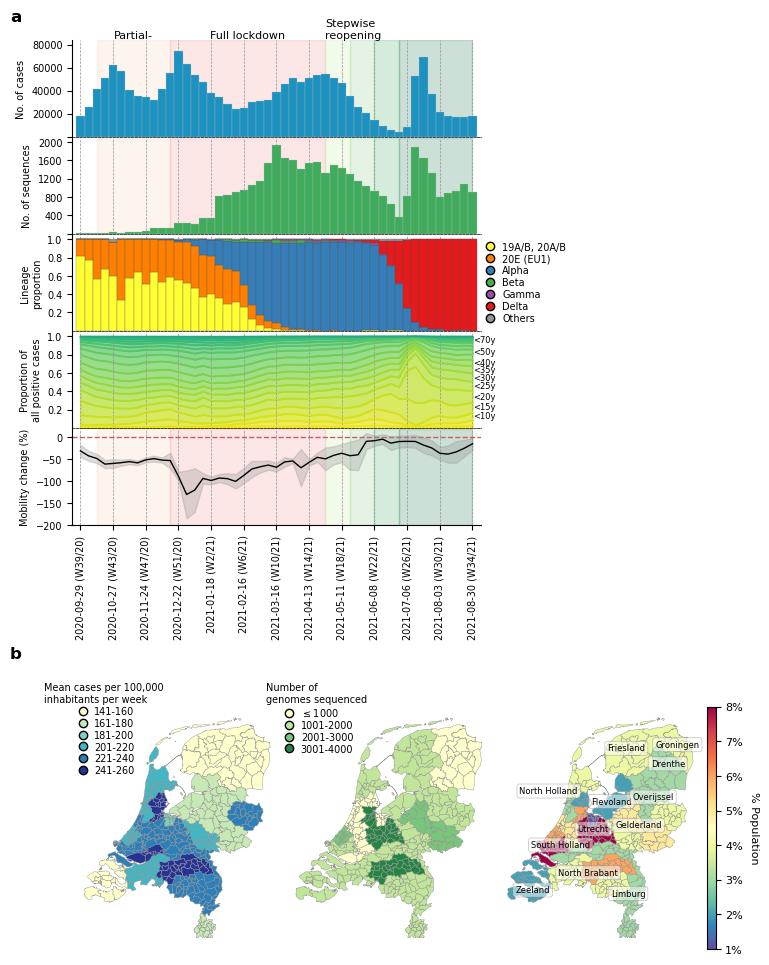

In [134]:
nextclade_colors = {'19A':'#ffff33', '19B':'#ffff33', '20A':'#ffff33', '20B':'#ffff33',
                    '20E (EU1)':'#ff7f00',
                    '20I (Alpha, V1)':'#377eb8',
                    '20H (Beta, V2)':'#4daf4a', 
                    '20J (Gamma, V3)':'#984ea3',
                    '21A (Delta)':'#e41a1c', '21I (Delta)':'#e41a1c', '21J (Delta)':'#e41a1c', #
                    }

colored_nc_groups = [['19A', '19B', '20A', '20B', '20C'], ['20E (EU1)'], ['20I (Alpha, V1)'], ['20H (Beta, V2)'], ['20J (Gamma, V3)'], ['21A (Delta)', '21I (Delta)', '21J (Delta)'], 
                     ['21F (Iota)', '21E (Theta)', '20G', '21C (Epsilon)', '21B (Kappa)', '21H (Mu)', '21G (Lambda)', '21D (Eta)', '20D']]

ggd_to_color = {'GGD Regio Utrecht':"#8dd3c7", 'GGD Flevoland':'#fccde5', 'GGD Fryslan':"#ffed6f", 'GGD Groningen':'#ffffb3', 
                'GGD Drenthe':'#ccebc5', 'GGD Zeeland':'#bebada',
                'GGD Limburg-Noord':'#bdbdbd', 'GGD Zuid-Limburg':'#636363', 
                'GGD West-Brabant':'#cb181d', 'GGD Hart voor Brabant':'#fb6a4a', 'GGD Brabant-Zuidoost':'#fcae91', 
                'GGD Noord- en Oost-Gelderland':'#d94701', 'Veiligheids- en Gezondheidsregio Gelderland-Midden':'#d94701', 'GGD Gelderland-Zuid':'#d94701', 
                'GGD IJsselland':'#238b45', 'GGD Regio Twente':'#bae4b3',
                'GGD Hollands-Midden':'#08519c', 'GGD Haaglanden':'#3182bd', 'GGD Rotterdam-Rijnmond':'#6baed6', 'Dienst Gezondheid & Jeugd ZHZ':'#bdd7e7',
                'GGD Gooi en Vechtstreek':"#54278f", 'GGD Amsterdam':'#756bb1', 'GGD Kennemerland':'#9e9ac8', 'GGD Zaanstreek/Waterland':'#bcbddc', 'GGD Hollands-Noorden':'#dadaeb'
                }

def ax_cosmetics_a(ax, i, xtick_sep=4): 
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(axis='x', ls='--', lw=0.5, zorder=-100, color='#929292')
    for axis in ["top", "right"]: 
        ax.spines[axis].set_visible(False)
        
    ax.set_xticks(np.arange(len(decimal_date_range))[::xtick_sep])
    ax.set_xlim(-1, len(decimal_date_range))
    if i == 4: 
        #ax.set_xticklabels(week_labels[::xtick_sep], fontsize=7, rotation=40)  
        ax.set_xticklabels(['%s (%s)'%(bt.calendarDate(date), week_labels[d]) for d, date in enumerate(decimal_date_range)][::xtick_sep], fontsize=7, rotation=90)  
    else: 
        ax.set_xticklabels([])
        ax.tick_params(axis='x', bottom=False)
        ax.spines['bottom'].set_linestyle('--')
        ax.spines['bottom'].set_linewidth(0.5)        
    return 

with plt.style.context('default'): 
    fig = plt.figure(figsize=(8.3, 11.8))
    gs = GridSpec(nrows=2, ncols=1, hspace=0.5, height_ratios=[2, 1])
    gs0 = gs[0].subgridspec(nrows=1, ncols=2, wspace=0.1, width_ratios=[2,1])
    
    ### (a) ###
    gs00 = gs0[0].subgridspec(nrows=5, ncols=1, hspace=0.01)
    bar_width = 1.
    bar_lw = 0.2
    # number of NL cases per week (panel 1)
    ax = fig.add_subplot(gs00[0])
    ax.bar(np.arange(len(decimal_date_range)), nl_case_counts.loc['total'].to_numpy(), width=bar_width, color="#1d91c0", edgecolor="#bdbdbd", linewidth=bar_lw, zorder=100)
    ax.set_ylim(0, max(nl_case_counts.loc['total'].to_numpy())*1.12)
    ax.set_yticks(np.linspace(0, 8e4, 5))
    ax.set_yticklabels([''] + list(np.linspace(2e4, 8e4, 4).astype(np.int32)))
    ax.set_ylabel('No. of cases', fontsize=7)    
    ax_cosmetics_a(ax, i=0)
    
    # lockdown shading 
    # soft lockdown 
    min_date, max_date = bt.decimalDate("2020-10-14"), bt.decimalDate("2020-12-14")
    min_date_idx = np.argmin([abs(d - min_date) for d in decimal_date_range])
    max_date_idx = np.argmin([abs(d - max_date) for d in decimal_date_range])
    ax.axvspan(min_date_idx, max_date_idx, color="#fddbc7", alpha=0.3, zorder=0)
    ax.text(x=min_date_idx + (max_date_idx-min_date_idx)/2 , 
            y=max(nl_case_counts.loc['total'].to_numpy())*1.12,  
            s="Partial-", fontsize=8, ha="center", va="bottom", zorder=100)
    
    # hard lockdown 
    min_date, max_date = bt.decimalDate("2020-12-15"), bt.decimalDate("2021-04-28")
    min_date_idx = np.argmin([abs(d - min_date) for d in decimal_date_range])
    max_date_idx = np.argmin([abs(d - max_date) for d in decimal_date_range])
    ax.axvspan(min_date_idx, max_date_idx, color="#f48582", alpha=0.2, zorder=0)
    ax.text(x=min_date_idx + (max_date_idx-min_date_idx)/2 , 
            y=max(nl_case_counts.loc['total'].to_numpy())*1.12, 
            s="Full lockdown", fontsize=8, ha="center", va="bottom", zorder=100)
    
    # reopening 
    for (min_date, max_date), color in zip([('2021-04-28', '2021-05-19'), ('2021-05-19', '2021-06-05'), ('2021-06-05', '2021-06-26'), ('2021-06-26', '2021-08-31')], 
                                           ['#c2e699','#78c679','#31a354','#006837']):
        min_date, max_date = bt.decimalDate(min_date), bt.decimalDate(max_date)
        min_date_idx = np.argmin([abs(d - min_date) for d in decimal_date_range])
        max_date_idx = np.argmin([abs(d - max_date) for d in decimal_date_range])
        ax.axvspan(min_date_idx, max_date_idx, color=color, alpha=0.2, zorder=0)
    
        if color == '#c2e699': 
            ax.text(x=min_date_idx, y=max(nl_case_counts.loc['total'].to_numpy())*1.12, 
                    s="Stepwise\nreopening", fontsize=8, ha="left", va="bottom", zorder=100)
            
    # number of sequences per week ()
    ax = fig.add_subplot(gs00[1])
    ax.bar(np.arange(len(decimal_date_range)), nl_sequence_counts['seq_n'].to_numpy(), width=bar_width, color="#41ab5d", edgecolor="#bdbdbd", linewidth=bar_lw, zorder=100)
    ax.set_ylim(0, 2000*1.05)
    ax.set_yticks(np.linspace(0, 2000, 6))
    ax.set_yticklabels([''] + list(np.linspace(400, 2000, 5).astype(np.int32)))
    ax.set_ylabel('No. of sequences', fontsize=7)
    ax_cosmetics_a(ax, i=1) 
    
    # lockdown shading 
    # soft lockdown 
    min_date, max_date = bt.decimalDate("2020-10-14"), bt.decimalDate("2020-12-14")
    min_date_idx = np.argmin([abs(d - min_date) for d in decimal_date_range])
    max_date_idx = np.argmin([abs(d - max_date) for d in decimal_date_range])
    ax.axvspan(min_date_idx, max_date_idx, color="#fddbc7", alpha=0.3, zorder=0)
    
    # hard lockdown 
    min_date, max_date = bt.decimalDate("2020-12-15"), bt.decimalDate("2021-04-28")
    min_date_idx = np.argmin([abs(d - min_date) for d in decimal_date_range])
    max_date_idx = np.argmin([abs(d - max_date) for d in decimal_date_range])
    ax.axvspan(min_date_idx, max_date_idx, color="#f48582", alpha=0.2, zorder=0)
    
    # reopening 
    for (min_date, max_date), color in zip([('2021-04-28', '2021-05-19'), ('2021-05-19', '2021-06-05'), ('2021-06-05', '2021-06-26'), ('2021-06-26', '2021-08-31')], 
                                           ['#c2e699','#78c679','#31a354','#006837']):
        min_date, max_date = bt.decimalDate(min_date), bt.decimalDate(max_date)
        min_date_idx = np.argmin([abs(d - min_date) for d in decimal_date_range])
        max_date_idx = np.argmin([abs(d - max_date) for d in decimal_date_range])
        ax.axvspan(min_date_idx, max_date_idx, color=color, alpha=0.2, zorder=0)
    
    # stacked nextclade 
    ax = fig.add_subplot(gs00[2])    
    bottom_arr = np.zeros(len(decimal_date_range))
    for group in colored_nc_groups: 
        ax.bar(np.arange(len(decimal_date_range)), nl_sequence_counts[group].sum(axis=1).to_numpy(), width=bar_width, 
               color=nextclade_colors[group[0]] if group[0] in nextclade_colors else '#969696', edgecolor="#525252", 
               linewidth=bar_lw, bottom=bottom_arr, zorder=100)
        bottom_arr += nl_sequence_counts[group].sum(axis=1).to_numpy()
    ax.set_ylim(0, 1.05)
    ax.set_yticks(np.linspace(0.2, 1., 5))
    ax.set_ylabel('Lineage\nproportion', fontsize=7)    
    ax_cosmetics_a(ax, i=2)
    
    legend_elements = []
    for label, group in zip(['19A/B, 20A/B', '20E (EU1)', 'Alpha', 'Beta', 'Gamma', 'Delta', 'Others'], colored_nc_groups): 
        legend_elements.append(Line2D([0], [0], marker='o', color='k', label=label,
                                      markerfacecolor=nextclade_colors[group[0]] if group[0] in nextclade_colors else '#969696',
                                      markersize=6, lw=0.))
    legend = ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1., 0.5), handletextpad=0.2,
                       labelspacing=0.2, borderaxespad=0., borderpad=0., frameon=False, fontsize=7,)
    
    # Age positivity 
    ax = fig.add_subplot(gs00[3])
    cmap = sns.color_palette("viridis_r", len(list(age_positivity_df)))
    prev_y_arr = np.zeros(len(age_positivity_df.index))
    for a, age_range in enumerate(list(age_positivity_df)): 
        x_arr = age_positivity_df.index.to_numpy()
        x_arr = [np.argmin([abs(d - bt.decimalDate(re.search("\d+\-\d+\-\d+", str(x)).group())) for d in decimal_date_range]) for x in x_arr]
        y_arr = age_positivity_df[age_range].to_numpy()
        
        ax.plot(x_arr, prev_y_arr + y_arr, color=cmap[a], lw=1., zorder=100)
        ax.fill_between(x_arr, y1=prev_y_arr, y2=prev_y_arr+y_arr, color=cmap[a], alpha=0.7)
        if a in [2, 3, 4, 5, 6, 7, 8, 10, 14]: 
            ax.text(s='<%sy'%(age_range.split('-')[0]), x=x_arr[-1]+0.02, y=list(prev_y_arr+y_arr)[-1] - y_arr[-1]/2, 
                    fontsize=6, ha='left', va='center')
        prev_y_arr += y_arr
        
    ax.set_ylim(0., 1.05)
    ax.set_yticks(np.linspace(0.2, 1., 5))
    ax.set_ylabel('Proportion of\nall positive cases', fontsize=7)    
    ax_cosmetics_a(ax, i=3)
    
    # Google mobility 
    ax = fig.add_subplot(gs00[4])
    
    y_arr = []
    y_sd_arr = []
    for d, date in enumerate(date_range):
        date_df_group = df_group[(df_group.index>=date - dt.timedelta(days=6))&(df_group.index<=date)].copy()
        y_arr.append(date_df_group['total'].mean())
        y_sd_arr.append(date_df_group['total'].std())
    y_arr = np.array(y_arr)
    y_sd_arr = np.array(y_sd_arr)
    
    ax.plot(np.arange(len(decimal_date_range)), y_arr, lw=1., c='k', zorder=100)
    ax.fill_between(np.arange(len(decimal_date_range)), y1=y_arr-y_sd_arr, y2=y_arr+y_sd_arr, color='#929292', zorder=50, alpha=0.3)
    ax.set_yticks(np.arange(-200, 10, 50))
    ax.axhline(0., ls='--', lw=1., color='indianred')
    # lockdown shading 
    # soft lockdown 
    min_date, max_date = bt.decimalDate("2020-10-14"), bt.decimalDate("2020-12-14")
    min_date_idx = np.argmin([abs(d - min_date) for d in decimal_date_range])
    max_date_idx = np.argmin([abs(d - max_date) for d in decimal_date_range])
    ax.axvspan(min_date_idx, max_date_idx, color="#fddbc7", alpha=0.3, zorder=0)
    
    # hard lockdown 
    min_date, max_date = bt.decimalDate("2020-12-15"), bt.decimalDate("2021-04-28")
    min_date_idx = np.argmin([abs(d - min_date) for d in decimal_date_range])
    max_date_idx = np.argmin([abs(d - max_date) for d in decimal_date_range])
    ax.axvspan(min_date_idx, max_date_idx, color="#f48582", alpha=0.2, zorder=0)
    
    # reopening 
    for (min_date, max_date), color in zip([('2021-04-28', '2021-05-19'), ('2021-05-19', '2021-06-05'), ('2021-06-05', '2021-06-26'), ('2021-06-26', '2021-08-31')], 
                                           ['#c2e699','#78c679','#31a354','#006837']):
        min_date, max_date = bt.decimalDate(min_date), bt.decimalDate(max_date)
        min_date_idx = np.argmin([abs(d - min_date) for d in decimal_date_range])
        max_date_idx = np.argmin([abs(d - max_date) for d in decimal_date_range])
        ax.axvspan(min_date_idx, max_date_idx, color=color, alpha=0.2, zorder=0)
    
    ax.set_ylabel('Mobility change (%)', fontsize=7)    
    #ax.set_ylim(0., 1.05)
    #ax.set_yticks(np.linspace(0.2, 1., 5))
    ax_cosmetics_a(ax, i=4)
    
    ### (c) cases and sequences on map ### 
    gs1 = gs[1].subgridspec(nrows=1, ncols=4, wspace=0.01, width_ratios=[1,1,1,0.04])
    # case density 
    ax = fig.add_subplot(gs1[0])
    # create color map of ggdid 
    geomap_data['mean_case_density'] = geomap_data['GGD_regio'].map(nl_case_per100k.mean(axis=1))
    cmap_cols = ['#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
    cmap = LinearSegmentedColormap.from_list("mean_case_density", colors=cmap_cols,  N=len(cmap_cols))
    geomap_data.plot(column='mean_case_density', ax=ax, cmap=cmap,  edgecolor='#929292', lw=0.3)
    ax.axis('off')
    # legend 
    bins = list(np.linspace(140, 260, len(cmap_cols)+1))
    legend_elements = []
    for _, b in enumerate(bins): 
        if _ == 0: 
            continue 
        else: 
            label = '%i-%i'%(bins[_-1]+1, b)
        legend_elements.append(Line2D([0], [0], marker='o', color='k', label=label,
                                      markerfacecolor=cmap_cols[_-1], markersize=6, lw=0.))
    legend = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.15, 1.1), handletextpad=0.2,
                       labelspacing=0.2, borderaxespad=0., borderpad=0., frameon=False, fontsize=7, 
                       title="Mean cases per 100,000\ninhabitants per week")
    plt.setp(legend.get_title(), fontsize=7)
    
    # sequence sampled
    ax = fig.add_subplot(gs1[1])
    
    # create color map of ggdid 
    ggd_to_total_sampled = {ggd:len(meta_data[meta_data["mapped_ggd"]==ggd]) for ggd in meta_data["mapped_ggd"].unique()}
    geomap_data["sampled_n"] = geomap_data["GGD_regio"].map(ggd_to_total_sampled)
    geomap_data["sampled_n_density"] = geomap_data["sampled_n"]/sum(ggd_to_total_sampled.values())
    geomap_data['sampled_n_col_cat'] = np.ceil(geomap_data["sampled_n"]/1000).astype(int)
    #display (geomap_data[pd.isna(geomap_data["sampled_n_density"])])
    cmap_cols = ['#ffffcc','#c2e699','#78c679','#238443'] #['#ffffcc','#d9f0a3','#addd8e','#78c679','#31a354','#006837']
    cmap = LinearSegmentedColormap.from_list("density_per_100000", 
                                             colors=cmap_cols, 
                                             N=len(cmap_cols))
    #geomap_data.plot(column='sampled_n_density', ax=ax, cmap=cmap,  edgecolor='#929292', lw=0.3)
    geomap_data.plot(column='sampled_n_col_cat', ax=ax, cmap=cmap,  edgecolor='#929292', lw=0.3)
    ax.axis('off')
    # legend 
    bins = [1, 2, 3, 4]
    legend_elements = []
    for _, b in enumerate(bins): 
        if _ == 0: 
            label = r'$\leq$' + '%i'%(b*1000)
        else:
            label = '%i-%i'%(bins[_-1]*1000+1, b*1000)
        legend_elements.append(Line2D([0], [0], marker='o', color='k', label=label,
                                      markerfacecolor=cmap_cols[_], markersize=6, lw=0.))
    legend = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.1, 1.1), handletextpad=0.2,
                       labelspacing=0.2, borderaxespad=0., borderpad=0., frameon=False, fontsize=7, 
                       title="Number of\ngenomes sequenced")
    plt.setp(legend.get_title(), fontsize=7)
    
    # map legend 
    ax = fig.add_subplot(gs1[2])
    #"Bevolkingsaantal"
    geomap_data.plot(column='pop_density_cat', ax=ax, cmap='Spectral_r', edgecolor='#929292', lw=0.3,)# legend=True)
    ax.axis('off')
    ggd_df = geomap_data.dissolve(by='Provincie', as_index=False)
    ggd_df['coords'] = ggd_df['geometry'].apply(lambda x: x.representative_point().coords[:])
    ggd_df['coords'] = [coords[0] for coords in ggd_df['coords']]
    # adding an annotation
    bbox_props = dict(boxstyle="round", fc="w", ec="gray", alpha=0.5, lw=0.5)
    fsize = 6.
    for idx, row in ggd_df.iterrows():
        if row["Provincie"] in ["Zuid-Holland",]:
            ax.annotate(text=re.sub("Zuid-", "South ", row["Provincie"]), xy=row['coords'], color='black', va="top",
                           ha='center', bbox=bbox_props, fontsize=fsize)
        elif row["Provincie"] in ["Noord-Holland",]:
            ax.annotate(text=re.sub("Noord-", "North ", row["Provincie"]), xy=row['coords'], color='black', va="bottom",
                           ha='right', bbox=bbox_props, fontsize=fsize)
        else: 
            ax.annotate(text=re.sub("Noord-", "North ", row["Provincie"]), xy=row['coords'], color='black', va="bottom",
                           ha='center', bbox=bbox_props, fontsize=fsize)
            
    # colorbar 
    cax = fig.add_subplot(gs1[3])
    sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=1., vmax=8.))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=8) 
    cbar.ax.set_yticklabels(["%i%%"%(i) for i in np.arange(1, 9)])
    cbar.ax.text(x=1.25, y=0.5, s='% Population', ha='center', va='center', fontsize=8, rotation=270, transform=ax.transAxes)
    
    fig.text(s='a', x=0.05, y=.9, fontsize=12, va='center', ha='left', fontweight='semibold',)
    fig.text(s='b', x=0.05, y=.36, fontsize=12, va='center', ha='left', fontweight='semibold',)
    
    plt.savefig('./manuscript/figure1.png', dpi=330, bbox_inches='tight')
    plt.show()

## Figure 2 - Introductions of VOCs

In [373]:
region_list = ['Africa', 'Asia', 'Oceania', 'SouthAmerica', 'NorthAmerica', 'Europe', 'Netherlands']
print_region = ["Africa", "Asia", "Oceania", "South America", "North America", "Europe", "Netherlands"]
col_list = ['#8dd3c7','#b3de69','#bebada','#fb8072','#80b1d3','#fdb462','#929292']
region_col_dict = {region:col_list[i] for i, region in enumerate(region_list)}
travel_ban = {'alpha':{'Country':'UK', "From":"2020-12-20", "To":"2021-03-09"}, 
              'beta':{"Country":"South Africa", "From":"2021-01-23", "To":"2021-06-01"}, 
              'gamma':{"Country":"Brazil", "From":"2021-01-23", "To":"2021-06-01"}, 
              'delta':{"Country":"India", "From":"2021-04-26", "To":"2021-06-01"},}
print_var = ['Alpha', 'Beta', 'Gamma', "Delta"]
subfig_label = ['a', 'b', 'c', 'd']

def load_overseas_tree(fpath):
    tree_obj = bt.loadNexus(fpath, absoluteTime=False)
    tree_obj.traverse_tree() ## required to set heights

    # traverse tree to get most_recent_date 
    most_recent_date = max([bt.decimalDate(k.name.split("|")[2]) for k in tree_obj.Objects if k.branchType == "leaf" and not re.search('WIV04', k.name)])
    tree_obj.traverse_tree() ## required to set heights
    tree_obj.setAbsoluteTime(most_recent_date) ## set absolute time of all branches by specifying date of most recent tip
        
    return tree_obj

def get_all_desc_nodes(node): 
    curr_desc = node.children
    all_desc = []
    while len(curr_desc) > 0: 
        all_desc += curr_desc
        temp_desc = []
        for desc in curr_desc: 
            if desc.branchType == 'node': 
                temp_desc += desc.children 
        curr_desc = temp_desc[:]
    return all_desc

In [374]:
variant_to_subtype_trees = {}

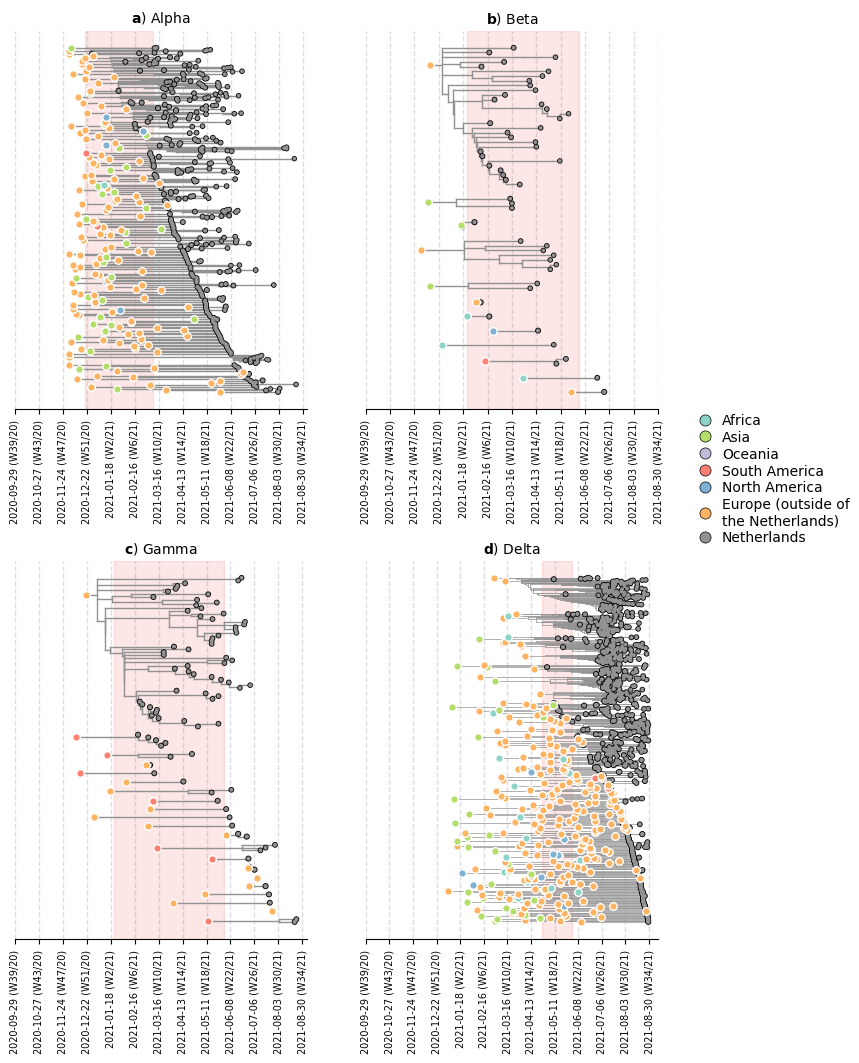

In [375]:
with plt.style.context("default"): 
    fig = plt.figure(figsize=(8.3, 11.8))
    gs = GridSpec(nrows=2, ncols=2, wspace=0.2, hspace=0.4)
    
    variant_to_anc_region = {}
    for v, variant in enumerate(['alpha', 'beta', 'gamma', 'delta']):
        row_i, col_i = np.floor(v/2).astype(np.int32), int(v%2)
        ax = fig.add_subplot(gs[row_i, col_i])
        
        # load tree 
        ll = load_overseas_tree('./trees/mugration_%s/annotated_tree.nexus'%(variant))
        
        try: 
            subtype_trees = variant_to_subtype_trees[variant]
            #print (variant, len(subtype_trees))
        except: 
            # find all NL subtrees 
            traitName = "region"
            subtype_trees={'Netherlands':[],'Others':[],'ancestor':[]}
            for l in ll.Objects: 
                k = l 
                kp = l.parent 

                ## get current node's and its parent's trait states
                try: 
                    kloc=k.traits[traitName] # trait of k
                except: 
                    kloc="ancestor"

                if traitName in k.parent.traits:
                    kploc=kp.traits[traitName] # trait of parent 
                    kpc=kploc if kploc == "Netherlands" else "Others"
                else:
                    kploc='ancestor'
                    kpc='ancestor'

                kc = kloc if kloc == "Netherlands" else "Others"

                ## if states do not match
                if kc!=kpc and kc in ["Netherlands",]:
                    traverse_condition=lambda w:w.traits[traitName]==kc
                    #print('subtree resulting from %s>%s switch, traversing within %s'%(kpc,kc,kc))
                    subtree=ll.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

                    if subtree: ## if the conditional subtree traversal failed because no tips were encountered None is returned
                        subtree.traverse_tree()
                        subtree.sortBranches()
                        #tree_strings[kc].append(subtree.toString()) ## remember subtree string, subtree object itself
                        subtype_trees[kc].append((kpc,subtree))
            variant_to_subtype_trees[variant] = subtype_trees
        
        #print (subtype_trees)
        # plot subtrees 
        c_func=lambda k: region_col_dict[k.traits["region"]] ## colour of branches
        s_func=lambda k: 10-10*k.height/ll.treeHeight ## size of tips
        
        cumulative_y=0

        for t,tr in enumerate(sorted(subtype_trees["Netherlands"],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
            origin,loc_tree=tr ## get origin of subtree, subtree itself
            if origin == "ancestor": 
                continue 
            x_attr=lambda k: k.absoluteTime ## x coordinate of branches will be absoluteTime attribute
            y_attr=lambda k: k.y+cumulative_y
            
            oriX=loc_tree.root.absoluteTime-loc_tree.root.length
            if oriX < bt.decimalDate("2020-12-01"): #################!!!!
                continue
            if variant == 'delta' and oriX < bt.decimalDate('2021-01-01'): 
                continue 
            if variant == 'beta' and t == 20: 
                loc_tree.root.parent.traits['region'] = 'Europe'
            oriY=loc_tree.root.y+cumulative_y
            
            oriC='dimgrey' if origin=='ancestor' else c_func(loc_tree.root.parent)
            anc_region = loc_tree.root.parent.traits["region"]
            try:
                variant_to_anc_region[variant].append(anc_region)
            except: 
                variant_to_anc_region[variant] = [anc_region]
            
            anc_size = 30 
            ax.scatter(oriX,oriY,anc_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
            
            width_branch = 0.5 if variant == 'delta' else 1.
            loc_tree.plotTree(ax,x_attr=x_attr,y_attr=y_attr,colour=c_func,width=width_branch)
            loc_tree.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size=s_func,colour=c_func,zorder=100)

            increment = 2 
            cumulative_y+=loc_tree.ySpan+increment ## increment y displacement 
            
            
        # plot travel ban period 
        ax.axvspan(bt.decimalDate(travel_ban[variant]['From']), 
                   bt.decimalDate(travel_ban[variant]['To']), color="#f48582", alpha=0.2, zorder=0)
        
        for axis in ["left", "top", "right"]: 
            ax.spines[axis].set_visible(False)
        ax.tick_params(axis="y", left=False, right=False)
        ax.set_yticklabels([])
        ax.set_xticks(decimal_date_range[::4])
        ax.set_xticklabels(['%s (%s)'%(bt.calendarDate(date), week_labels[d]) for d, date in enumerate(decimal_date_range)][::4], fontsize=7, rotation=90)
        ax.grid(axis="x", which="both", ls="--", lw=1., alpha=0.3, zorder=-100, c="#929292")
        
        ax.set_title(r'$\bf{%s}$'%(subfig_label[v]) + ') %s'%(print_var[v]), fontsize=10)
        
    # legend 
    legend_elements = []
    for i, region in enumerate(print_region): 
        legend_elements.append(Line2D([0], [0], marker='o', color='k', label='Europe (outside of\nthe Netherlands)' if region == 'Europe' else region, 
                                      markerfacecolor=region_col_dict[region_list[i]], markersize=8, lw=0., mew=0.5))
    legend = fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.94, 0.5), handletextpad=0.2,
                       labelspacing=0.2, borderaxespad=0., borderpad=0., frameon=False, fontsize=10,)
    plt.setp(legend.get_title(), fontsize=8)
    plt.savefig('./manuscript/figure2.png', dpi=330, bbox_inches='tight')
    plt.show()

In [376]:
variant_nearest_overseas_freq = {}
for v, variant in enumerate(['alpha', 'beta', 'gamma', 'delta']):
    
    # load tree 
    ll = ete3.Tree('./trees/treetime_%s/timetree.newick'%(variant))
    all_leaves = ll.get_leaves()
    
    dutch_leaves_to_skip = []
    for node in ll.traverse(): 
        node_leaves = node.get_leaves()
        node_leaf_countries = [leaf.name.split('|')[4] if leaf.name != 'WIV04' else 'China' for leaf in node_leaves]
        if set(node_leaf_countries) == set(['Netherlands']): 
            # get closest leaf
            dutch_leaves_to_skip += list(set(node_leaves)-set([node.get_closest_leaf()[0]]))
    dutch_leaves_to_skip = list(set(dutch_leaves_to_skip))
    
    # get all Dutch sequences 
    dutch_leaves = [leaf for leaf in all_leaves if leaf.name != 'WIV04' and leaf.name.split('|')[4] == 'Netherlands']
    dutch_leaves = list(set(dutch_leaves)-set(dutch_leaves_to_skip))
    
    overseas_freq = {}
    for d, dutch_leaf in enumerate(dutch_leaves):
        nearest_leaf_idx = np.argmin(np.array([dutch_leaf.get_distance(leaf) for leaf in all_leaves if leaf != dutch_leaf]))
        nearest_leaf = all_leaves[nearest_leaf_idx]
        
        nearest_continent = nearest_leaf.name.split('|')[3]
        nearest_country = nearest_leaf.name.split("|")[4]
        if nearest_country != 'Netherlands': 
            
            # must be ancestral to dutch sequence 
            ca = ll.get_common_ancestor([dutch_leaf, nearest_leaf])
            if ca.get_distance(nearest_leaf) > ca.get_distance(dutch_leaf):
                continue 
            
            try: 
                overseas_freq[nearest_continent][nearest_country] += 1
            except: 
                try: 
                    overseas_freq[nearest_continent][nearest_country] = 1
                except: 
                    overseas_freq[nearest_continent] = {nearest_country:1}
    
    variant_nearest_overseas_freq[variant] = overseas_freq

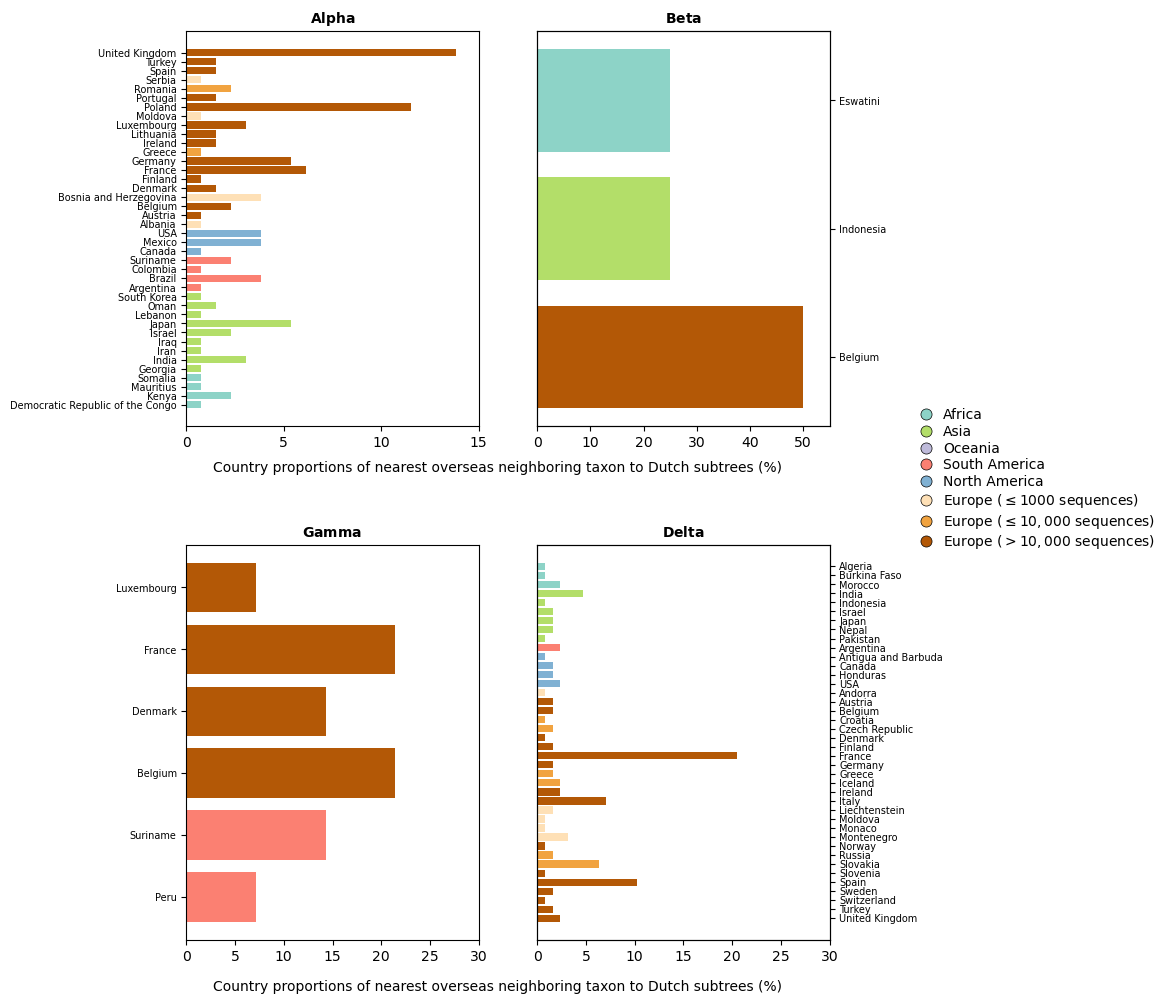

In [377]:
region_list = ['Africa', 'Asia', 'Oceania', 'SouthAmerica', 'NorthAmerica', 'Europe', 'Netherlands']
print_region = ["Africa", "Asia", "Oceania", "South America", "North America", "Europe (outside of\nthe Netherlands)"]
print_voc = ['Alpha', 'Beta', 'Gamma', 'Delta']
col_list = ['#8dd3c7','#b3de69','#bebada','#fb8072','#80b1d3','#fdb462','#929292']

eu_seq_dist = pd.read_csv("./data/eu_seq_n_gisaid_Oct21.csv").set_index('country') # get number of sequences deposited in GISAID in EU countries
eu_col_list = ['#b35806','#f1a340','#fee0b6']

with plt.style.context('default'): 
    fig = plt.figure(figsize=(8.3, 11.8))
    gs = GridSpec(nrows=2, ncols=2, hspace=0.3)
    for v, variant in enumerate(['alpha', 'beta', 'gamma', 'delta']): 
        i = int(v/2)
        j = int(v%2)
        
        ax = fig.add_subplot(gs[i,j])
        if j > 0: 
            ax2 = ax.twinx()
        
        prev_x = 0 
        all_x_arr = []
        all_countries_N = 0
        for r, region in enumerate(region_list): 
            
            try: 
                country_freq = variant_nearest_overseas_freq[variant][region]
            except: 
                continue 
            all_countries_N += sum(country_freq.values())
            
        for r, region in enumerate(region_list): 
            if region not in variant_to_anc_region[variant]: 
                continue 
            try: 
                country_freq = variant_nearest_overseas_freq[variant][region]
            except: 
                continue 
                
            x_arr = []
            y_arr = []
            curr_col_list = []
            for country in sorted(country_freq.keys()): 
                if country == 'DemocraticRepublicoftheCongo': 
                    print_country = 'Democratic Republic of the Congo'
                elif country == 'SouthKorea': 
                    print_country = 'South Korea'
                elif country == 'BosniaandHerzegovina': 
                    print_country = 'Bosnia and Herzegovina'
                elif country == 'UnitedKingdom': 
                    print_country = 'United Kingdom'
                elif country == 'BurkinaFaso': 
                    print_country = 'Burkina Faso'
                elif country == 'SouthAfrica': 
                    print_country = 'South Africa'
                elif country == 'AntiguaandBarbuda': 
                    print_country = 'Antigua and Barbuda'
                elif country == 'CzechRepublic': 
                    print_country = 'Czech Republic'
                else: 
                    print_country = country
                x_arr.append(print_country)
                y_arr.append(country_freq[country]/all_countries_N)
                
                if region == 'Europe': 
                    seq_n = eu_seq_dist.loc[print_country, 'seq_n']
                    if seq_n <= 1000: 
                        ci = 2
                    elif seq_n <= 10000: 
                        ci = 1
                    else: 
                        ci = 0
                    curr_col_list.append(eu_col_list[ci])
                else: 
                    curr_col_list.append(col_list[r])

            y_arr = np.array(y_arr) * 100
            ax.barh(prev_x + np.arange(len(x_arr)), y_arr, color=curr_col_list)
            
            prev_x += len(x_arr)
            all_x_arr += x_arr
        
        if j > 0: 
            ax.invert_yaxis()
            ax2.set_ylim(ax.get_ylim())
            ax2.set_yticks(np.arange(prev_x))
            ax2.set_yticklabels(all_x_arr, fontsize=7)
            ax.set_yticklabels([])
            ax.tick_params(axis='y', left=False)
            
        else:
            ax.set_yticks(np.arange(prev_x))
            ax.set_yticklabels(all_x_arr, fontsize=7)
                
        ax.set_title(r"$\bf{%s}$"%(print_voc[v]), fontsize=10)
        if v == 0: 
            ax.set_xlim(0, 15)
            ax.set_xticks(np.linspace(0, 15, 4))
        elif v > 1: 
            ax.set_xlim(0, 30)
        else: 
            ax.set_xlim(0, 55)
            
    fig.text(s="Country proportions of nearest overseas neighboring taxon to Dutch subtrees (%)", 
             x=0.5, y=0.07, fontsize=10, ha='center', va='center')
    fig.text(s="Country proportions of nearest overseas neighboring taxon to Dutch subtrees (%)", 
             x=0.5, y=0.51, fontsize=10, ha='center', va='center')
    
    # legend 
    legend_elements = []
    for i, region in enumerate(print_region): 
        if region == 'Europe (outside of\nthe Netherlands)': 
            for ci, label in zip(np.arange(3)[::-1], ['Europe (' + r'$\leq1000$' + ' sequences)', 'Europe (' + r'$\leq10,000$' + ' sequences)', 'Europe (' + r'$>10,000$' + ' sequences)']):
                legend_elements.append(Line2D([0], [0], marker='o', color='k', label=label, 
                                              markerfacecolor=eu_col_list[ci], 
                                              markersize=8, lw=0., mew=0.5))
        else: 
            legend_elements.append(Line2D([0], [0], marker='o', color='k', label=region, 
                                          markerfacecolor=region_col_dict[region_list[i]], 
                                          markersize=8, lw=0., mew=0.5))
    legend = fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), handletextpad=0.2,
                       labelspacing=0.2, borderaxespad=0., borderpad=0., frameon=False, fontsize=10,)
    plt.setp(legend.get_title(), fontsize=8)
    
    plt.savefig('./manuscript/SFigure1.png', dpi=330, bbox_inches='tight')
    plt.show()

In [ ]:
variant_to_subtype_trees = {}

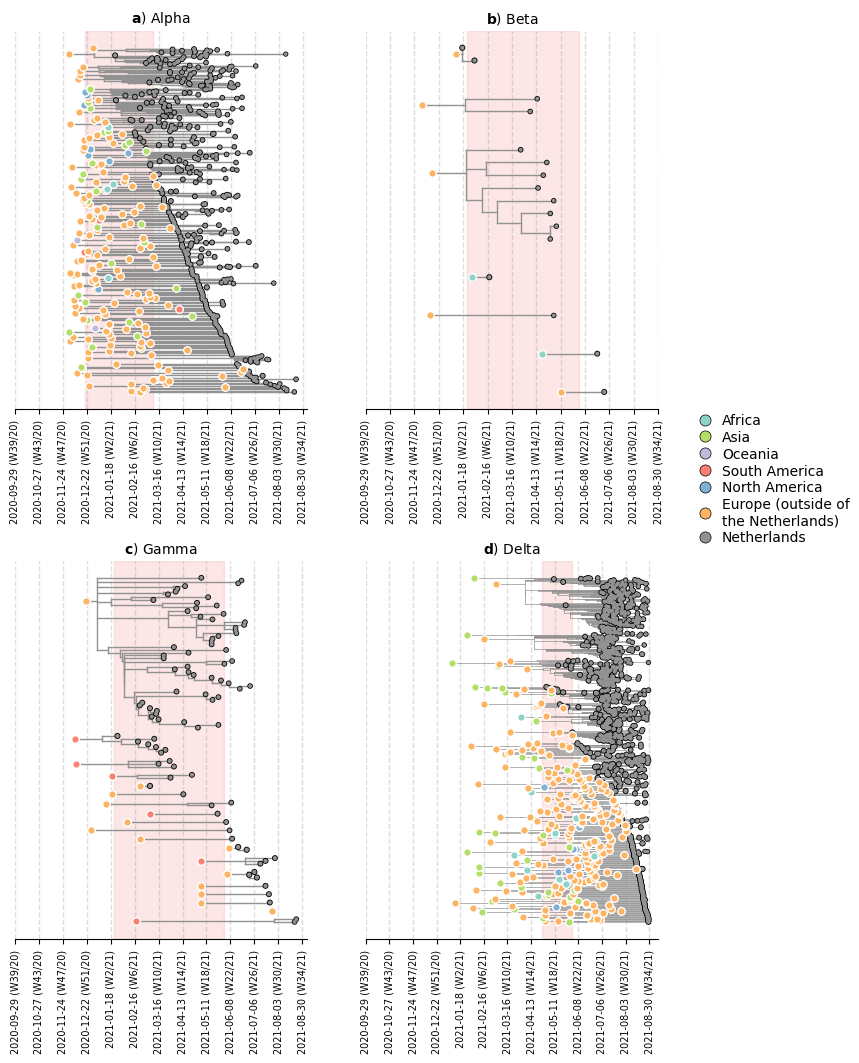

In [348]:
# repeat analysis with boostrap sample 
with plt.style.context("default"): 
    fig = plt.figure(figsize=(8.3, 11.8))
    gs = GridSpec(nrows=2, ncols=2, wspace=0.2, hspace=0.4)
    
    variant_to_anc_region = {}
    for v, variant in enumerate(['alpha', 'beta', 'gamma', 'delta']):
        row_i, col_i = np.floor(v/2).astype(np.int32), int(v%2)
        ax = fig.add_subplot(gs[row_i, col_i])
        
        # load tree 
        ll = load_overseas_tree('./trees/mugration1_%s/annotated_tree.nexus'%(variant))
        
        try: 
            subtype_trees = variant_to_subtype_trees[variant]
            #print (variant, len(subtype_trees))
        except: 
            # find all NL subtrees 
            traitName = "region"
            subtype_trees={'Netherlands':[],'Others':[],'ancestor':[]}
            for l in ll.Objects: 
                k = l 
                kp = l.parent 

                ## get current node's and its parent's trait states
                try: 
                    kloc=k.traits[traitName] # trait of k
                except: 
                    kloc="ancestor"

                if traitName in k.parent.traits:
                    kploc=kp.traits[traitName] # trait of parent 
                    kpc=kploc if kploc == "Netherlands" else "Others"
                else:
                    kploc='ancestor'
                    kpc='ancestor'

                kc = kloc if kloc == "Netherlands" else "Others"

                ## if states do not match
                if kc!=kpc and kc in ["Netherlands",]:
                    traverse_condition=lambda w:w.traits[traitName]==kc
                    #print('subtree resulting from %s>%s switch, traversing within %s'%(kpc,kc,kc))
                    subtree=ll.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

                    if subtree: ## if the conditional subtree traversal failed because no tips were encountered None is returned
                        subtree.traverse_tree()
                        subtree.sortBranches()
                        #tree_strings[kc].append(subtree.toString()) ## remember subtree string, subtree object itself
                        subtype_trees[kc].append((kpc,subtree))
            variant_to_subtype_trees[variant] = subtype_trees
        
        #print (subtype_trees)
        # plot subtrees 
        c_func=lambda k: region_col_dict[k.traits["region"]] ## colour of branches
        s_func=lambda k: 10-10*k.height/ll.treeHeight ## size of tips
        
        cumulative_y=0

        for t,tr in enumerate(sorted(subtype_trees["Netherlands"],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
            origin,loc_tree=tr ## get origin of subtree, subtree itself
            if origin == "ancestor": 
                continue 
            x_attr=lambda k: k.absoluteTime ## x coordinate of branches will be absoluteTime attribute
            y_attr=lambda k: k.y+cumulative_y
            
            oriX=loc_tree.root.absoluteTime-loc_tree.root.length
            if oriX < bt.decimalDate("2020-12-01"): #################!!!!
                continue
            if variant == 'delta' and oriX < bt.decimalDate('2021-01-01'): 
                continue 
            if variant == 'beta' and t == 20: 
                loc_tree.root.parent.traits['region'] = 'Europe'
            oriY=loc_tree.root.y+cumulative_y
            
            oriC='dimgrey' if origin=='ancestor' else c_func(loc_tree.root.parent)
            anc_region = loc_tree.root.parent.traits["region"]
            try:
                variant_to_anc_region[variant].append(anc_region)
            except: 
                variant_to_anc_region[variant] = [anc_region]
            
            anc_size = 30 
            ax.scatter(oriX,oriY,anc_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
            
            width_branch = 0.5 if variant == 'delta' else 1.
            loc_tree.plotTree(ax,x_attr=x_attr,y_attr=y_attr,colour=c_func,width=width_branch)
            loc_tree.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size=s_func,colour=c_func,zorder=100)

            increment = 2 
            cumulative_y+=loc_tree.ySpan+increment ## increment y displacement 
            
        # plot travel ban period 
        ax.axvspan(bt.decimalDate(travel_ban[variant]['From']), 
                   bt.decimalDate(travel_ban[variant]['To']), color="#f48582", alpha=0.2, zorder=0)
        
        for axis in ["left", "top", "right"]: 
            ax.spines[axis].set_visible(False)
        ax.tick_params(axis="y", left=False, right=False)
        ax.set_yticklabels([])
        ax.set_xticks(decimal_date_range[::4])
        ax.set_xticklabels(['%s (%s)'%(bt.calendarDate(date), week_labels[d]) for d, date in enumerate(decimal_date_range)][::4], fontsize=7, rotation=90)
        ax.grid(axis="x", which="both", ls="--", lw=1., alpha=0.3, zorder=-100, c="#929292")
        
        ax.set_title(r'$\bf{%s}$'%(subfig_label[v]) + ') %s'%(print_var[v]), fontsize=10)
        
    # legend 
    legend_elements = []
    for i, region in enumerate(print_region): 
        legend_elements.append(Line2D([0], [0], marker='o', color='k', label='Europe (outside of\nthe Netherlands)' if region == 'Europe' else region, 
                                      markerfacecolor=region_col_dict[region_list[i]], markersize=8, lw=0., mew=0.5))
    legend = fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.94, 0.5), handletextpad=0.2,
                       labelspacing=0.2, borderaxespad=0., borderpad=0., frameon=False, fontsize=10,)
    plt.setp(legend.get_title(), fontsize=8)
    plt.savefig('./manuscript/Sfigure2.png', dpi=330, bbox_inches='tight')
    plt.show()

In [349]:
variant_nearest_overseas_freq = {}
for v, variant in enumerate(['alpha', 'beta', 'gamma', 'delta']):
    
    # load tree 
    ll = ete3.Tree('./trees/treetime1_%s/timetree.newick'%(variant))
    all_leaves = ll.get_leaves()
    
    dutch_leaves_to_skip = []
    for node in ll.traverse(): 
        node_leaves = node.get_leaves()
        node_leaf_countries = [leaf.name.split('|')[4] if leaf.name != 'WIV04' else 'China' for leaf in node_leaves]
        if set(node_leaf_countries) == set(['Netherlands']): 
            # get closest leaf
            dutch_leaves_to_skip += list(set(node_leaves)-set([node.get_closest_leaf()[0]]))
    dutch_leaves_to_skip = list(set(dutch_leaves_to_skip))
    
    # get all Dutch sequences 
    dutch_leaves = [leaf for leaf in all_leaves if leaf.name != 'WIV04' and leaf.name.split('|')[4] == 'Netherlands']
    dutch_leaves = list(set(dutch_leaves)-set(dutch_leaves_to_skip))
    
    overseas_freq = {}
    for d, dutch_leaf in enumerate(dutch_leaves):
        nearest_leaf_idx = np.argmin(np.array([dutch_leaf.get_distance(leaf) for leaf in all_leaves if leaf != dutch_leaf]))
        nearest_leaf = all_leaves[nearest_leaf_idx]
        
        nearest_continent = nearest_leaf.name.split('|')[3]
        nearest_country = nearest_leaf.name.split("|")[4]
        if nearest_country != 'Netherlands': 
            
            # must be ancestral to dutch sequence 
            ca = ll.get_common_ancestor([dutch_leaf, nearest_leaf])
            if ca.get_distance(nearest_leaf) > ca.get_distance(dutch_leaf):
                continue 
            
            try: 
                overseas_freq[nearest_continent][nearest_country] += 1
            except: 
                try: 
                    overseas_freq[nearest_continent][nearest_country] = 1
                except: 
                    overseas_freq[nearest_continent] = {nearest_country:1}
    
    variant_nearest_overseas_freq[variant] = overseas_freq

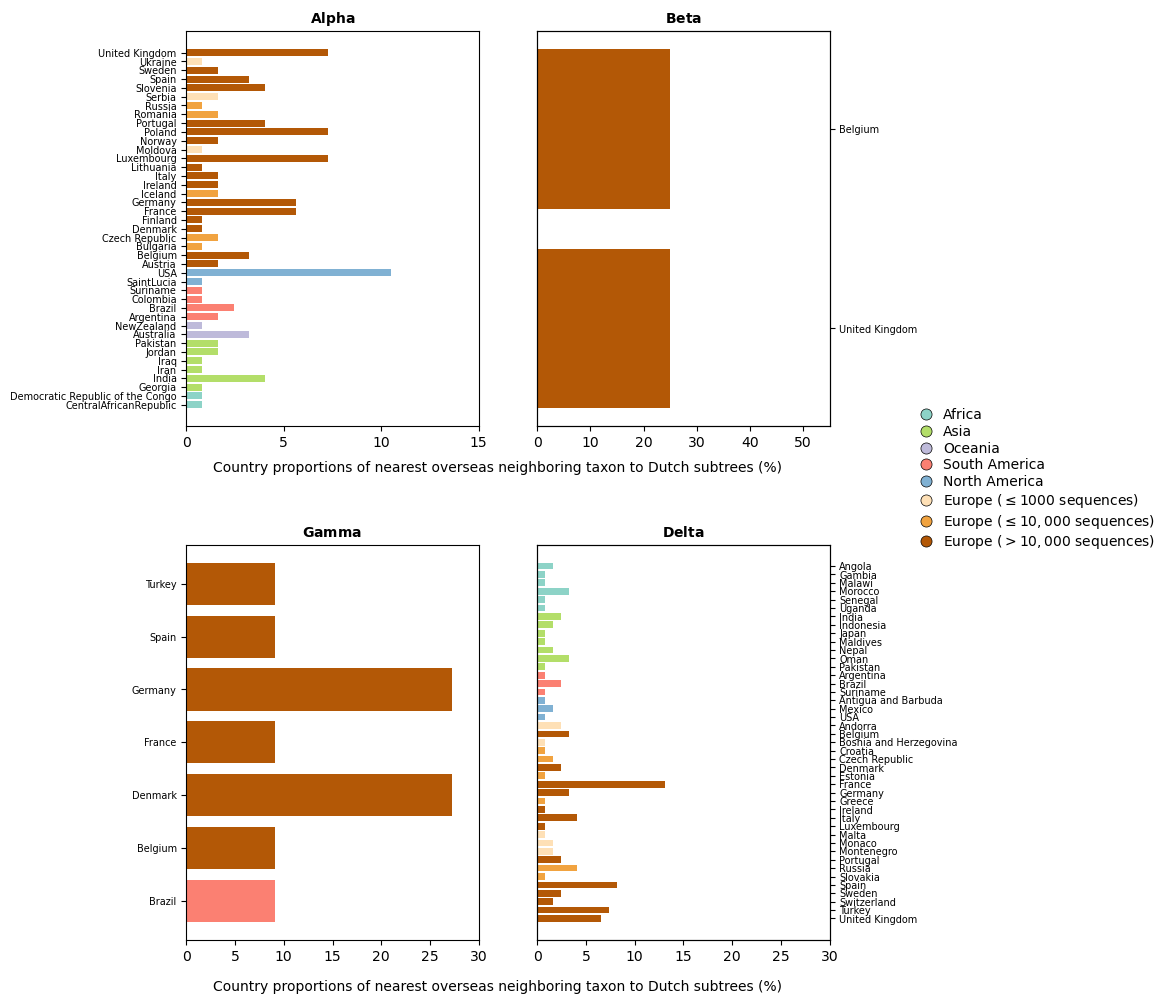

In [371]:
region_list = ['Africa', 'Asia', 'Oceania', 'SouthAmerica', 'NorthAmerica', 'Europe', 'Netherlands']
print_region = ["Africa", "Asia", "Oceania", "South America", "North America", "Europe (outside of\nthe Netherlands)"]
print_voc = ['Alpha', 'Beta', 'Gamma', 'Delta']
col_list = ['#8dd3c7','#b3de69','#bebada','#fb8072','#80b1d3','#fdb462','#929292']

eu_seq_dist = pd.read_csv("./data/eu_seq_n_gisaid_Oct21.csv").set_index('country') # get number of sequences deposited in GISAID in EU countries
eu_col_list = ['#b35806','#f1a340','#fee0b6']

with plt.style.context('default'): 
    fig = plt.figure(figsize=(8.3, 11.8))
    gs = GridSpec(nrows=2, ncols=2, hspace=0.3)
    for v, variant in enumerate(['alpha', 'beta', 'gamma', 'delta']): 
        i = int(v/2)
        j = int(v%2)
        
        ax = fig.add_subplot(gs[i,j])
        if j > 0: 
            ax2 = ax.twinx()
        
        prev_x = 0 
        all_x_arr = []
        all_countries_N = 0
        for r, region in enumerate(region_list): 
            
            try: 
                country_freq = variant_nearest_overseas_freq[variant][region]
            except: 
                continue 
            all_countries_N += sum(country_freq.values())
            
        for r, region in enumerate(region_list): 
            if region not in variant_to_anc_region[variant]: 
                continue 
            try: 
                country_freq = variant_nearest_overseas_freq[variant][region]
            except: 
                continue 
                
            x_arr = []
            y_arr = []
            curr_col_list = []
            for country in sorted(country_freq.keys()): 
                if country == 'DemocraticRepublicoftheCongo': 
                    print_country = 'Democratic Republic of the Congo'
                elif country == 'SouthKorea': 
                    print_country = 'South Korea'
                elif country == 'BosniaandHerzegovina': 
                    print_country = 'Bosnia and Herzegovina'
                elif country == 'UnitedKingdom': 
                    print_country = 'United Kingdom'
                elif country == 'BurkinaFaso': 
                    print_country = 'Burkina Faso'
                elif country == 'SouthAfrica': 
                    print_country = 'South Africa'
                elif country == 'AntiguaandBarbuda': 
                    print_country = 'Antigua and Barbuda'
                elif country == 'CzechRepublic': 
                    print_country = 'Czech Republic'
                else: 
                    print_country = country
                x_arr.append(print_country)
                y_arr.append(country_freq[country]/all_countries_N)
                
                if region == 'Europe': 
                    seq_n = eu_seq_dist.loc[print_country, 'seq_n']
                    if seq_n <= 1000: 
                        ci = 2
                    elif seq_n <= 10000: 
                        ci = 1
                    else: 
                        ci = 0
                    curr_col_list.append(eu_col_list[ci])
                else: 
                    curr_col_list.append(col_list[r])

            y_arr = np.array(y_arr) * 100
            ax.barh(prev_x + np.arange(len(x_arr)), y_arr, color=curr_col_list)
            
            prev_x += len(x_arr)
            all_x_arr += x_arr
        
        if j > 0: 
            ax.invert_yaxis()
            ax2.set_ylim(ax.get_ylim())
            ax2.set_yticks(np.arange(prev_x))
            ax2.set_yticklabels(all_x_arr, fontsize=7)
            ax.set_yticklabels([])
            ax.tick_params(axis='y', left=False)
            
        else:
            ax.set_yticks(np.arange(prev_x))
            ax.set_yticklabels(all_x_arr, fontsize=7)
                
        ax.set_title(r"$\bf{%s}$"%(print_voc[v]), fontsize=10)
        if v == 0: 
            ax.set_xlim(0, 15)
            ax.set_xticks(np.linspace(0, 15, 4))
        elif v > 1: 
            ax.set_xlim(0, 30)
        else: 
            ax.set_xlim(0, 55)
            
    fig.text(s="Country proportions of nearest overseas neighboring taxon to Dutch subtrees (%)", 
             x=0.5, y=0.07, fontsize=10, ha='center', va='center')
    fig.text(s="Country proportions of nearest overseas neighboring taxon to Dutch subtrees (%)", 
             x=0.5, y=0.51, fontsize=10, ha='center', va='center')
    
    # legend 
    legend_elements = []
    for i, region in enumerate(print_region): 
        if region == 'Europe (outside of\nthe Netherlands)': 
            for ci, label in zip(np.arange(3)[::-1], ['Europe (' + r'$\leq1000$' + ' sequences)', 'Europe (' + r'$\leq10,000$' + ' sequences)', 'Europe (' + r'$>10,000$' + ' sequences)']):
                legend_elements.append(Line2D([0], [0], marker='o', color='k', label=label, 
                                              markerfacecolor=eu_col_list[ci], 
                                              markersize=8, lw=0., mew=0.5))
        else: 
            legend_elements.append(Line2D([0], [0], marker='o', color='k', label=region, 
                                          markerfacecolor=region_col_dict[region_list[i]], 
                                          markersize=8, lw=0., mew=0.5))
    legend = fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), handletextpad=0.2,
                       labelspacing=0.2, borderaxespad=0., borderpad=0., frameon=False, fontsize=10,)
    plt.setp(legend.get_title(), fontsize=8)
    
    plt.savefig('./manuscript/SFigure3.png', dpi=330, bbox_inches='tight')
    plt.show()

## Figure 3 - Within-country circulation of Alpha and Delta

In [201]:
ggd_df = geomap_data.dissolve(by='ggd_id', as_index=False)
ggd_df['coords'] = ggd_df['geometry'].apply(lambda x: x.representative_point().coords[:])
ggd_df['coords'] = [coords[0] for coords in ggd_df['coords']]
ggd_df.head()

,ggd_id,geometry,Gemeentenaam,Gemeentecode,Gemeentenummer,Provincie,Provinciecode,Provincienummer,Veiligheidsregio,Veiligheidsregiocode,...,Meldingen_100000,Ziekenhuisopnamen_100000,Overleden_100000,ObjectId,pop_density_cat,mean_case_density,sampled_n,sampled_n_density,sampled_n_col_cat,coords
0,0,"POLYGON ((4.96779 51.91009, 4.96413 51.91064, ...",Amersfoort,GM0307,307,Utrecht,PV26,26,Utrecht,VR09,...,8984.0,161.5,87.7,16,8.0,217.643137,3682,0.092410,4,"(5.142520546690204, 52.080452949762545)"
1,1,"MULTIPOLYGON (((5.56218 52.33126, 5.56195 52.3...",Almere,GM0034,34,Flevoland,PV24,24,Flevoland,VR25,...,9286.7,157.7,45.3,11,2.0,176.635294,1067,0.026779,2,"(5.516503849933034, 52.43215390816975)"
2,2,"MULTIPOLYGON (((5.81975 52.81728, 5.81711 52.8...",Achtkarspelen,GM0059,59,Friesland,PV21,21,Fryslân,VR02,...,8262.7,93.4,140.1,6,4.0,147.401961,1451,0.036417,2,"(5.82944880094159, 53.1078723154269)"
3,3,"MULTIPOLYGON (((7.18396 53.14232, 7.18317 53.1...",Appingedam,GM0003,3,Groningen,PV20,20,Groningen,VR01,...,2799.7,77.3,17.2,20,4.0,149.323529,912,0.022889,1,"(6.887314049045113, 53.1528488882378)"
4,4,"POLYGON ((6.51203 52.61365, 6.51115 52.61436, ...",Aa en Hunze,GM1680,1680,Drenthe,PV22,22,Drenthe,VR03,...,5523.9,27.5,78.6,3,3.0,142.829412,853,0.021408,1,"(6.691751667816376, 52.910004342011504)"


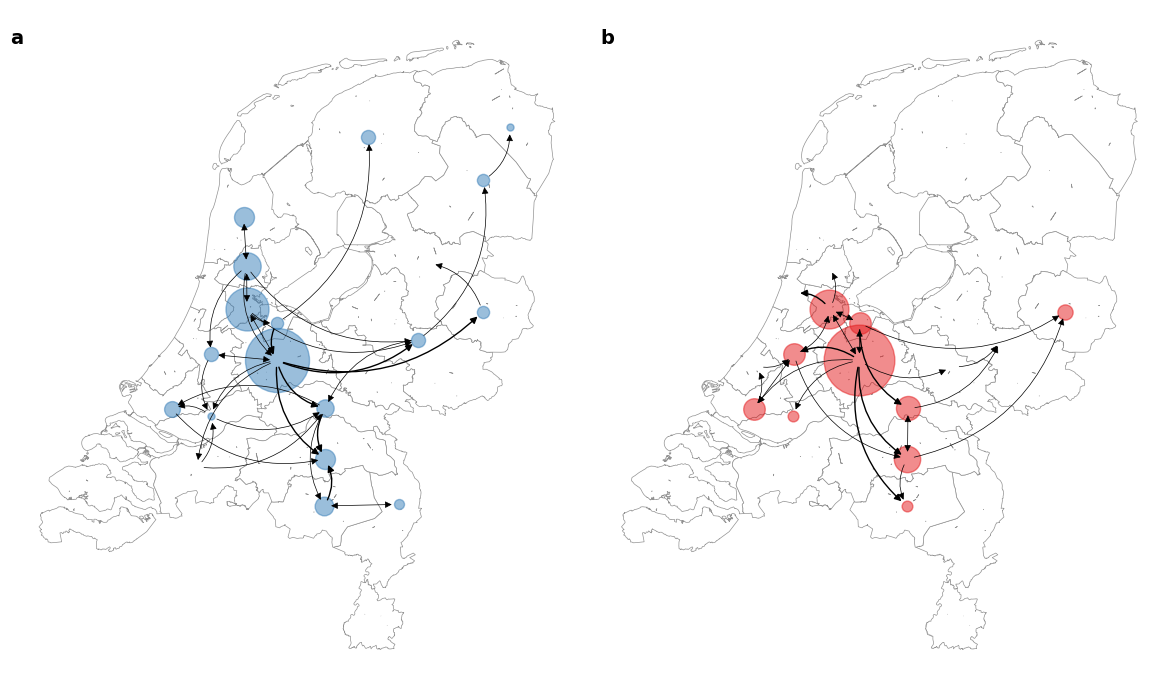

In [336]:
def plot_ss(ax, voc, cutoff_date):
    mcc_tab = pd.read_csv("./data/%s_mcc_tab.csv"%(voc))
    # convert coordinates to shapely object 
    start_mcc_tab = gpd.GeoDataFrame(mcc_tab.copy(), geometry=gpd.points_from_xy(mcc_tab.startLon,mcc_tab.startLat))
    end_mcc_tab = gpd.GeoDataFrame(mcc_tab.copy(), geometry=gpd.points_from_xy(mcc_tab.endLon,mcc_tab.endLat))
    start_mcc_tab.crs = geomap_data.crs
    end_mcc_tab.crs = geomap_data.crs
    # assign GGD
    for idx in geomap_data.index:
        # start
        pip = start_mcc_tab.within(geomap_data.loc[idx, 'geometry'])
        if pip.sum() > 0: 
            start_mcc_tab.loc[pip, 'start_ggd_id'] = geomap_data.loc[idx, 'ggd_id']
        # end
        pip = end_mcc_tab.within(geomap_data.loc[idx, 'geometry'])
        if pip.sum() > 0: 
            end_mcc_tab.loc[pip, 'end_ggd_id'] = geomap_data.loc[idx, 'ggd_id']

    start_end_same_mask = start_mcc_tab['start_ggd_id'] == end_mcc_tab['end_ggd_id']
    start_date_mask = start_mcc_tab['endYear']<=bt.decimalDate(date=cutoff_date)
    end_date_mask = end_mcc_tab['endYear']<=bt.decimalDate(date=cutoff_date)
    
    ggd_df.plot(ax=ax, edgecolor='#929292', color='white', lw=.5)
    # plot source-sink in the same province 
    #start_mcc_tab[start_date_mask&start_end_same_mask].plot(ax=ax, color="#e66101", markersize=12, alpha=.4, )
    #end_mcc_tab[end_date_mask&start_end_same_mask].plot(ax=ax, color="#e66101", markersize=12, alpha=.4, )
    # plot cross province events 
    #start_mcc_tab[start_date_mask&~start_end_same_mask].plot(ax=ax, color="#5e3c99", markersize=12, alpha=.4, )
    #end_mcc_tab[end_date_mask&~start_end_same_mask].plot(ax=ax, color="#5e3c99", markersize=12, alpha=.4, )
    
    fdf = start_mcc_tab[start_date_mask&start_end_same_mask].copy()
    for ggd_id in (fdf['start_ggd_id'].unique()): 
        center = ggd_df[ggd_df['ggd_id']==ggd_id]['coords'].iloc[0]
        circ = ax.scatter([center[0]], [center[-1]], 
                          s=5000*len(fdf[fdf['start_ggd_id']==ggd_id])/len(fdf), 
                          marker='o', color="#377eb8" if voc == 'Alpha' else '#e41a1c', alpha=0.5, zorder=1)
    
    start_ggd_id_arr = start_mcc_tab[start_date_mask&~start_end_same_mask&~pd.isna(start_mcc_tab['start_ggd_id'])&~pd.isna(end_mcc_tab['end_ggd_id'])]['start_ggd_id'].to_numpy()
    end_ggd_id_arr = end_mcc_tab[end_date_mask&~start_end_same_mask&~pd.isna(start_mcc_tab['start_ggd_id'])&~pd.isna(end_mcc_tab['end_ggd_id'])]['end_ggd_id'].to_numpy()
    ij_count = {}
    for i, j in zip(start_ggd_id_arr, end_ggd_id_arr): 
        try: 
            ij_count[(i,j)] += 1
        except: 
            ij_count[(i,j)] = 1
    
    skip = []
    for (i,j), count in ij_count.items():
        if (i,j) in skip: 
            continue 
            
        if (j, i) in ij_count:
            skip.append((j,i))
            
            P1 = ggd_df[ggd_df['ggd_id']==i]['coords'].iloc[0]
            P2 = ggd_df[ggd_df['ggd_id']==j]['coords'].iloc[0]
            ax.annotate("", 
                        xy=P2, xycoords='data', 
                        xytext=P1, textcoords='data', 
                        arrowprops=dict(arrowstyle="<|-|>", color="k",
                                        shrinkA=5, shrinkB=5,
                                        patchA=None, patchB=None,
                                        connectionstyle="arc3,rad=0",
                                        lw=0.5,), 
                        zorder=2)
        else: 
            if count > 1:
                lw=1.
            else: 
                lw=0.5
                #continue
            P1 = ggd_df[ggd_df['ggd_id']==i]['coords'].iloc[0]
            P2 = ggd_df[ggd_df['ggd_id']==j]['coords'].iloc[0]
            ax.annotate("", 
                        xy=P2, xycoords='data', 
                        xytext=P1, textcoords='data', 
                        arrowprops=dict(arrowstyle="-|>", color="k",
                                        shrinkA=5, shrinkB=5,
                                        patchA=None, patchB=None,
                                        connectionstyle="arc3,rad=.3",
                                        lw=lw,), 
                        zorder=1.)
    ax.axis('off')
    return 

with plt.style.context("default"):
    #ax = geoplot.kdeplot(mcc_tab, clip=geomap_data.geometry, shade=True, cmap='Reds', projection=geoplot.crs.AlbersEqualArea(),)
    #fig, ax = plt.subplots(1, 1)
    fig, axes = plt.subplots(1, 2, figsize=(11.8, 8.3))
    ax = axes[0]  
    plot_ss(ax, voc='Alpha', cutoff_date="2020-12-29")
    ax = axes[-1]  
    plot_ss(ax, voc='Delta', cutoff_date="2021-05-18")
    
    fig.text(s='a', x=0.01, y=.87, fontsize=14, va='center', ha='left', fontweight='semibold',)
    fig.text(s='b', x=0.51, y=.87, fontsize=14, va='center', ha='left', fontweight='semibold',)
    
    fig.tight_layout()
    plt.savefig('./manuscript/figure3.png', bbox_inches='tight', dpi=330,)
    plt.show()

## Figure 4 - Within-country circulation of Alpha and Delta

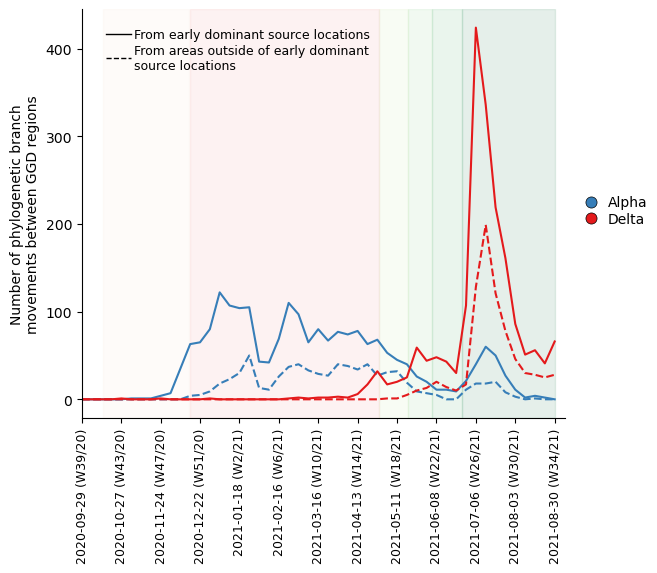

In [343]:
export_summary = pd.read_csv('./data/export_summary.csv')

growth_df = pd.read_csv('./data/table_observed_and_modelled_variant_proportions.csv')
week_map = {'W%02d'%int(re.search('\d+', week.split('/')[0]).group()):decimal_date_range[w] for w, week in enumerate(week_labels)}
growth_df['date'] = growth_df['RIVMweek'].str.split('-', expand=True)[1].map(week_map)
growth_df = growth_df[~pd.isna(growth_df['date'])]

alpha_delta_cols = ["#377eb8", '#e41a1c']

with plt.style.context('default'): 
    fig = plt.figure(figsize=(0.75*8.3, 0.45*11.8))
    gs = GridSpec(nrows=1, ncols=1, hspace=0.01)
    
    ax = fig.add_subplot(gs[0])
    for v, voc in enumerate(['alpha', 'delta']): 
        fdf = export_summary[export_summary['voc']==voc]
        ax.plot(fdf['date'], fdf['N'] - fdf['core_export_n'], ls='--', lw=1.5, color=alpha_delta_cols[v])
        ax.plot(fdf['date'], fdf['core_export_n'], ls='-', lw=1.5, color=alpha_delta_cols[v])
    
    # soft lockdown 
    min_date, max_date = bt.decimalDate("2020-10-14"), bt.decimalDate("2020-12-14")
    #print ('soft', min_date, max_date)
    ax.axvspan(min_date, max_date, color="#fddbc7", alpha=0.1, zorder=0)

    # hard lockdown 
    min_date, max_date = bt.decimalDate("2020-12-15"), bt.decimalDate("2021-04-28")
    #print ('hard', min_date, max_date)        
    ax.axvspan(min_date, max_date, color="#f48582", alpha=0.1, zorder=0)

    # reopening 
    for (min_date, max_date), color in zip([('2021-04-28', '2021-05-19'), ('2021-05-19', '2021-06-05'), ('2021-06-05', '2021-06-26'), ('2021-06-26', '2021-08-31')], 
                                           ['#c2e699','#78c679','#31a354','#006837']):         
        min_date, max_date = bt.decimalDate(min_date), bt.decimalDate(max_date)
        #print ('reopen', min_date, max_date)            
        ax.axvspan(min_date, max_date, color=color, alpha=0.1, zorder=0)
        
    ax.set_xticks(decimal_date_range[::4])
    ax.set_xlim(decimal_date_range[0], decimal_date_range[-1] + 7/365)    
    #ax.grid(axis='x', ls='--', c='#929292', zorder=-100)
    ax.set_xticklabels([])
    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)
    ax.set_ylabel('Number of phylogenetic branch\nmovements between GGD regions')

    """
    ax.set_xticklabels(week_labels[::4], rotation=90, fontsize=9)    
    """
    legend_elements = [Line2D([0], [0], marker='o', color='k', markerfacecolor=alpha_delta_cols[v], 
                              label='From early dominant source locations', markersize=0, lw=1., mew=0.5),
                       Line2D([0], [0], marker='o', color='k', markerfacecolor=alpha_delta_cols[v], 
                              label='From areas outside of early dominant\nsource locations', ls='--',
                              markersize=0, lw=1., mew=0.5)]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.05, 0.9), handletextpad=0.2,
              labelspacing=0.2, borderaxespad=0., borderpad=0., frameon=False, fontsize=9,)
    
    """#### 
    ax = fig.add_subplot(gs[1])
    for v, voc in enumerate(['alpha', 'delta']): 
        fdf = growth_df[growth_df['variant']==voc]
        ax.plot(fdf['date'], fdf['modelled_proportion'], lw=1.5, color='k')
        ax.scatter(fdf['date'], fdf['observerd_proportion'], color=alpha_delta_cols[v])
    
    # soft lockdown 
    min_date, max_date = bt.decimalDate("2020-10-14"), bt.decimalDate("2020-12-14")
    #print ('soft', min_date, max_date)
    ax.axvspan(min_date, max_date, color="#fddbc7", alpha=0.1, zorder=0)

    # hard lockdown 
    min_date, max_date = bt.decimalDate("2020-12-15"), bt.decimalDate("2021-04-28")
    #print ('hard', min_date, max_date)        
    ax.axvspan(min_date, max_date, color="#f48582", alpha=0.1, zorder=0)

    # reopening 
    for (min_date, max_date), color in zip([('2021-04-28', '2021-05-19'), ('2021-05-19', '2021-06-05'), ('2021-06-05', '2021-06-26'), ('2021-06-26', '2021-08-31')], 
                                           ['#c2e699','#78c679','#31a354','#006837']):         
        min_date, max_date = bt.decimalDate(min_date), bt.decimalDate(max_date)
        #print ('reopen', min_date, max_date)            
        ax.axvspan(min_date, max_date, color=color, alpha=0.1, zorder=0)
        
    ax.set_xticks(decimal_date_range[::4])
    ax.set_xlim(decimal_date_range[0], decimal_date_range[-1] + 7/365)    
    #ax.grid(axis='x', ls='--', c='#929292', zorder=-100)
    
    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)
        
    ax.set_xticklabels(["%s (%s)"%(bt.calendarDate(date), week_labels[d]) for d,date in enumerate(decimal_date_range)][::4], 
                       rotation=90, fontsize=9)
    ax.set_ylabel('Proportion of sequences')"""
    
    ax.set_xticks(decimal_date_range[::4])
    ax.set_xlim(decimal_date_range[0], decimal_date_range[-1] + 7/365)    
    #ax.grid(axis='x', ls='--', c='#929292', zorder=-100)    
    ax.set_xticklabels(["%s (%s)"%(bt.calendarDate(date), week_labels[d]) for d,date in enumerate(decimal_date_range)][::4], 
                       rotation=90, fontsize=9)
    
    # legend 
    legend_elements = []
    for v, voc in enumerate(['Alpha', 'Delta']): 
        legend_elements.append(Line2D([0], [0], marker='o', color='k', 
                                      markerfacecolor=alpha_delta_cols[v], 
                                      label=voc, markersize=8, lw=0., mew=0.5))
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.92, 0.5),
               handletextpad=0.2,
               labelspacing=0.2, borderaxespad=0., borderpad=0., frameon=False, fontsize=10,)
    
    plt.savefig('./manuscript/figure4.png', dpi=330, bbox_inches='tight')
    plt.show()